In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import lmfit

parent_parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(parent_parent_dir)
import scresonators as scres
import scresonators.src.plotter as plotter

# from bcqt-ctrl repo
# import helper_functions as hf

from pathlib import Path
from time import sleep, time
# from tqdm.auto import tqdm


In [2]:
# only S21 dBm has factor of 20, otherwise it'd be a factor of 10
# this is because P = V^2/R, so the V^2 gives an extra factor of 2

def s21_dbm_to_lin(dbm_ampl):
    return np.log10(dbm_ampl) * 20  

def s21_lin_to_dbm(lin_ampl):
    return 10**(lin_ampl/20)

def load_csv(path):
    
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(path, header=None)
    freqs = df[0].to_numpy()
    amps_dB = df[1].to_numpy()
    phases_init = df[2].to_numpy()

    max_phase_value = np.max(phases_init)
    min_phase_value = np.min(phases_init)
    if (max_phase_value > 2 * np.pi) or (min_phase_value < -2 * np.pi): #check if phases are in degrees or radians, convert as needed
        #phases are in degrees, we need to convert
        phases_new = np.unwrap(np.deg2rad(phases_init))
    else:
        #phases are in radians, good to go
        phases_new = np.unwrap(phases_init)

    return freqs, amps_dB, phases_new

def load_all_csvs_in_path(path, key='*', idx=None):
    """AI is creating summary for load_all_csvs_in_path

    Args:
        path ([type]): [description]
        key (str, optional): [description]. Defaults to '*'.
        idx ([type], optional): [description]. Defaults to None.

    Returns:
        [type]: [description]
    """
    data_files = glob.glob(path + key)
    
    if idx is not None:  # user wants to load a single file from dir
        idx = 0 if len(data_files) == 1 else idx  # set idx to 0 if there's only one file
        file = data_files[idx]
        df = pd.read_csv(file, sep=",", names=['Frequency','dBm','Phase'])
        freq = np.array(df['Frequency'])
        ampl = s21_lin_to_dbm(df['dBm'])
        phase = np.unwrap(np.deg2rad(df['Phase']))
        cmplx = ampl * np.exp(1j*phase)
        
        return freq, cmplx, df
    
    elif idx is None and len(data_files) != 1:  
        freq_dict, cmplx_dict, df_dict = {}, {}, {}
        for filepath in data_files:
            filename = os.path.basename(filepath)
            df = pd.read_csv(filepath, sep=",", names=['Frequency','dBm','Phase'])
            freq = np.array(df['Frequency'])
            ampl = s21_lin_to_dbm(df['dBm'])
            phase = np.unwrap(np.deg2rad(df['Phase']))
            cmplx = ampl * np.exp(1j*phase)
            
            freq_dict[filename] = freq
            cmplx_dict[filename] = cmplx
            df_dict[filename] = df
            
        return freq_dict, cmplx_dict, df_dict
        
    else:
        # idx is None and len(data_files) == 1
        print(f"idx={idx}, len(data_files)={len(data_files)}\n failed if & elif")
        raise
        
def preprocess_csv(file_path):
    """
    Preprocess a CSV file into a DataFrame. The CSV file is read starting from line 6,
    and the data in the first column is separated into respective columns by spaces.

    Parameters:
    file_path (str): Path to the input CSV file.

    Returns:
    pd.DataFrame: Preprocessed DataFrame with separated columns.
    """
    # Read the CSV file starting from line 6
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract the headers (assuming the first row from line 6 contains headers)
    headers = lines[5].strip().split()
    
    # Extract the data starting from line 7
    data = [line.strip().split() for line in lines[6:]]
    
    # Create a DataFrame
    df = pd.DataFrame(data, columns=headers)

    df = df.astype(float)

    return df


# load data from sample directory
# data_path = 'test_data/Cooldown53/Line3_NWNb2O5_15_01/NWNb2O5_15_01_6p335GHz/NWNb2O5_15_01_6p335GHz_-64dB_11mK_homophasal.csv'
data_path = 'test_data/Cooldown53/Line3_NWNb2O5_15_01/NWNb2O5_15_01_6p388GHz/NWNb2O5_15_01_6p388GHz_-62dB_11mK_homophasal.csv'
freqs, amps_dB, phases = load_csv(data_path)
phases = np.unwrap(phases)
amps_linear = 10 ** (amps_dB / 20)
cmplx = amps_linear * np.exp(1j*phases)

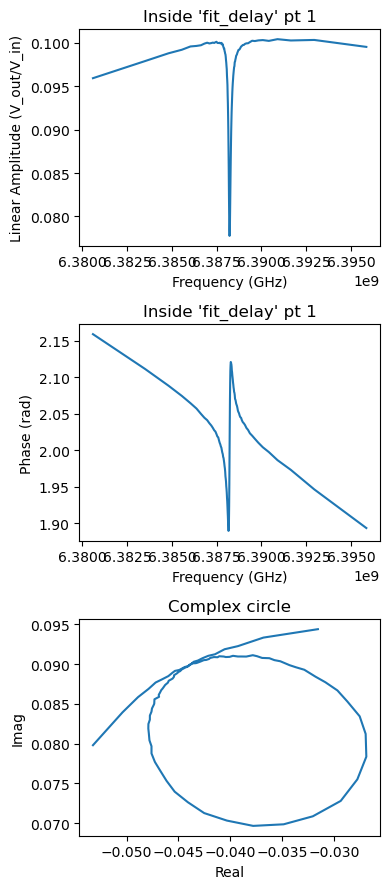

In [3]:
plt.figure(figsize=(4, 9))

plt.subplot(3,1,1)
plt.plot(freqs, amps_linear)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Linear Amplitude (V_out/V_in)')
plt.title("Inside 'fit_delay' pt 1")

plt.subplot(3,1,2)
plt.plot(freqs, phases)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Phase (rad)')
plt.title("Inside 'fit_delay' pt 1")       

plt.subplot(3,1,3)
plt.plot(cmplx.real, cmplx.imag)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('Complex circle')

plt.tight_layout()

In [4]:
dcm_method = scres.DCM()
FitRes = scres.Fitter(dcm_method)

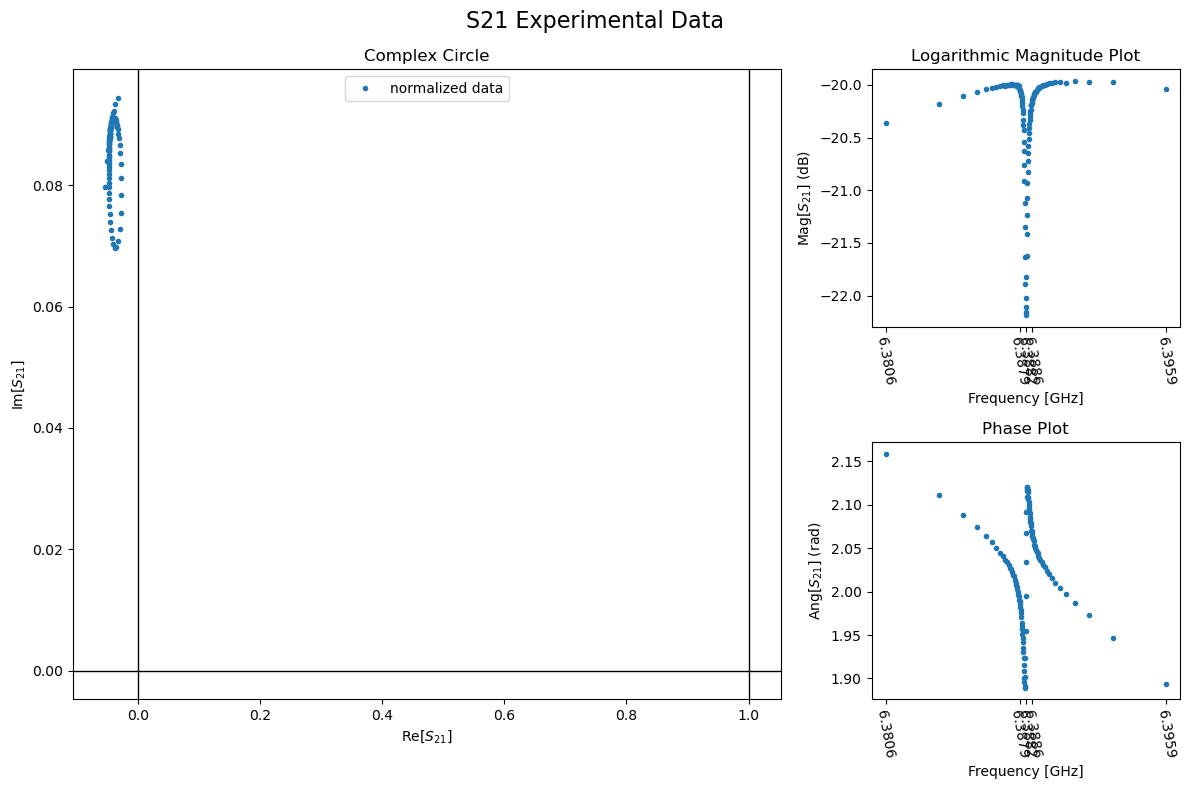

In [5]:
plot = plotter.Plotter(freqs, cmplx)

layout = [
    ["main", "main", "mag"],
    ["main", "main", "ang"]
]
fig1, ax_dict1 = plt.subplot_mosaic(layout, figsize=(12, 8))

fig1, ax_dict1 = plot.plot_before_fit(fig1, ax_dict1, horiz_line=True, vert_line=True, figure_title='S21 Experimental Data')

### User customization test 1

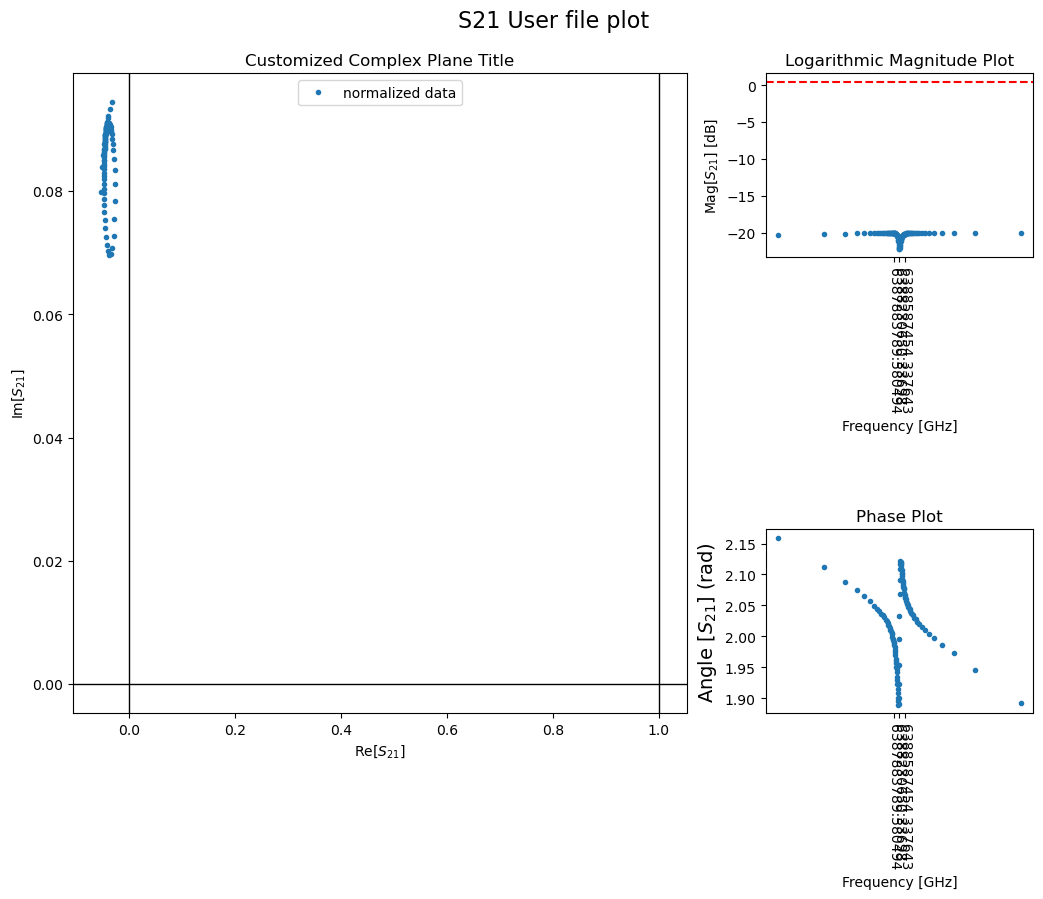

In [6]:
plot = plotter.Plotter(freqs, cmplx)

layout = [
    ["main", "main", "mag"],
    ["main", "main", "ang"]
]
fig1, ax_dict1 = plt.subplot_mosaic(layout, figsize=(12, 8))

fig1, ax_dict1 = plot.plot_before_fit(fig1, ax_dict1, horiz_line=True, vert_line=True, figure_title='S21 Experimental Data')

# plot.plot_preprocessing_steps(dcm_method)

for ax in ax_dict1.values():
    ax.cla()

# Complex circle plot
ax = ax_dict1["main"]
ax.plot(cmplx.real, cmplx.imag, '.', label="normalized data")
ax.set_xlabel("Re[$S_{21}$]")
ax.set_ylabel("Im[$S_{21}$]")
ax.axhline(y=0, color='black', linewidth=1) 
ax.axvline(x=1, color='black', linewidth=1) 
ax.axvline(x=0, color='black', linewidth=1) 
ax.set_title("Complex Plane")
ax.legend()
        
freq_factor = 1e9

n=4
num_freq_indices = len(freqs)
divided_index_width = num_freq_indices//n
freqs_indices_ticks = []
freqs_ticks = []
parser = divided_index_width
for i in range(n-1):
    freqs_indices_ticks.append(parser)
    freqs_ticks.append(freqs[parser])
    parser += divided_index_width
freqs_ticks_labels = [str(num) for num in freqs_ticks]

# Magnitude plot
ax_mag = ax_dict1["mag"]
ax_mag.plot(freqs, amps_dB, '.', label="normalized data")
ax_mag.set_xlabel("Frequency [GHz]")
ax_mag.set_xticks(freqs_ticks, labels=freqs_ticks_labels, rotation=270)  # Custom ticks
# ax_mag.set_xticklabels(freqs_ticks_labels, rotation=90)
ax_mag.set_ylabel("Mag[$S_{21}$] [dB]")
ax_mag.set_title("Logarithmic Magnitude Plot")
        
# Phase plot
ax_ang = ax_dict1["ang"]
ax_ang.plot(freqs, phases, '.', label="normalized data")
ax_ang.set_xlabel("Frequency [GHz]")
ax_ang.set_xticks(freqs_ticks, labels=freqs_ticks_labels, rotation=270)
ax_ang.set_ylabel("Ang[$S_{21}$] (rad)")
ax_ang.set_title("Phase Plot")
        
# Adjust the bottom, left, right, and top margins
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
        
fig1.suptitle("S21 User file plot", fontsize=16)


# User customization
# Change the title of the complex plane plot
ax_dict1["main"].set_title("Customized Complex Plane Title")

# Add a horizontal line to the magnitude plot
ax_dict1["mag"].axhline(y=0.5, color='red', linestyle='--')

# Change the font size of the phase plot's y-axis label
ax_dict1["ang"].set_ylabel("Angle [$S_{21}$] (rad)", fontsize=14)

# Modify the layout
fig1.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Show the customized plot
plt.show()

### User customization test 2

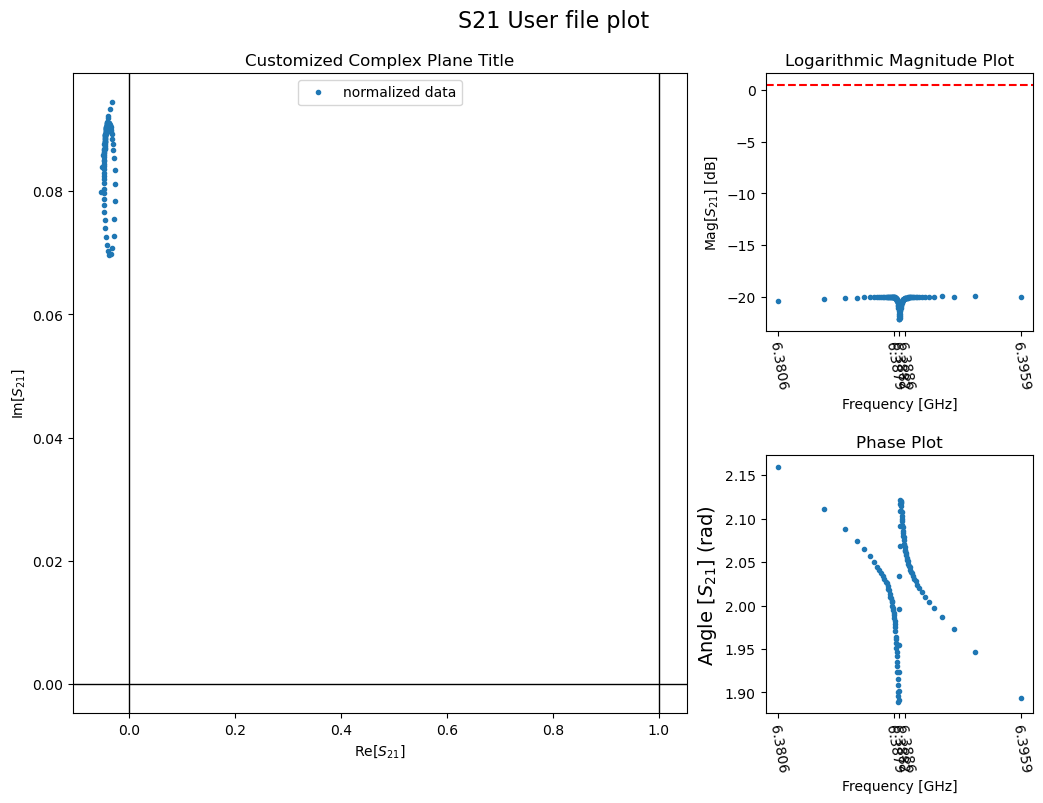

In [7]:
plot = plotter.Plotter(freqs, cmplx)

layout = [
    ["main", "main", "mag"],
    ["main", "main", "ang"]
]
fig1, ax_dict1 = plt.subplot_mosaic(layout, figsize=(12, 8))

fig1, ax_dict1 = plot.plot_before_fit(fig1, ax_dict1, horiz_line=True, vert_line=True, figure_title='S21 Experimental Data')

# plot.plot_preprocessing_steps(dcm_method)

for ax in ax_dict1.values():
    ax.cla()

# Complex circle plot
ax = ax_dict1["main"]
ax.plot(cmplx.real, cmplx.imag, '.', label="normalized data")
ax.set_xlabel("Re[$S_{21}$]")
ax.set_ylabel("Im[$S_{21}$]")
ax.axhline(y=0, color='black', linewidth=1) 
ax.axvline(x=1, color='black', linewidth=1) 
ax.axvline(x=0, color='black', linewidth=1) 
ax.set_title("Complex Plane")
ax.legend()
        
freq_factor = 1e9
rotation = 280

# Calculate the indices for `n` evenly spaced frequency markers
num_ticks = 5
indices = np.linspace(0, len(freqs) - 1, num_ticks, dtype=int)
freqs_ticks = freqs[indices]
freqs_ticks_labels = [f'{freq/freq_factor:.4f}' for freq in freqs_ticks]


# Magnitude plot
ax_mag = ax_dict1["mag"]
ax_mag.plot(freqs/freq_factor, amps_dB, '.', label="normalized data")
ax_mag.set_xlabel("Frequency [GHz]")
ax_mag.set_xticks(freqs_ticks/freq_factor, labels=freqs_ticks_labels, rotation=rotation)
ax_mag.set_ylabel("Mag[$S_{21}$] [dB]")
ax_mag.set_title("Logarithmic Magnitude Plot")
        
# Phase plot
ax_ang = ax_dict1["ang"]
ax_ang.plot(freqs/freq_factor, phases, '.', label="normalized data")
ax_ang.set_xlabel("Frequency [GHz]")
ax_ang.set_xticks(freqs_ticks/freq_factor, labels=freqs_ticks_labels, rotation=rotation)
ax_ang.set_ylabel("Ang[$S_{21}$] (rad)")
ax_ang.set_title("Phase Plot")
        
# Adjust the bottom, left, right, and top margins
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
        
fig1.suptitle("S21 User file plot", fontsize=16)


# User customization
# Change the title of the complex plane plot
ax_dict1["main"].set_title("Customized Complex Plane Title")

# Add a horizontal line to the magnitude plot
ax_dict1["mag"].axhline(y=0.5, color='red', linestyle='--')

# Change the font size of the phase plot's y-axis label
ax_dict1["ang"].set_ylabel("Angle [$S_{21}$] (rad)", fontsize=14)

# Modify the layout
fig1.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Show the customized plot
plt.show()

### User customization test 3

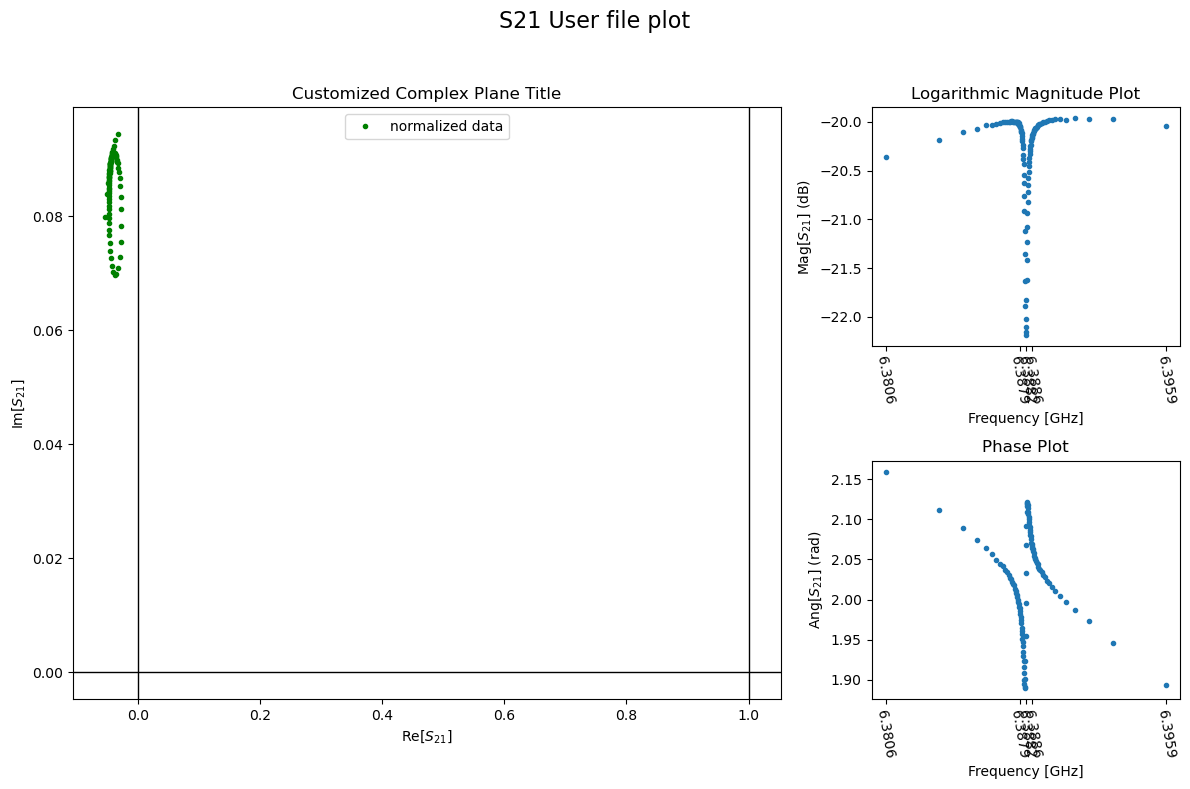

In [8]:
# Create the plot layout
layout = [
    ["main", "main", "mag"],
    ["main", "main", "ang"]
]
fig1, ax_dict1 = plt.subplot_mosaic(layout, figsize=(12, 8))

# Plot with plot_before_fit
fig1, ax_dict1 = plot.plot_before_fit(fig1, ax_dict1, horiz_line=True, vert_line=True, figure_title='S21 Experimental Data')

# Clear the specific axis you want to customize (e.g., "main")
ax_dict1["main"].cla()

# Now plot your custom plot on the "main" axis

# Complex circle plot on the "main" axis
ax = ax_dict1["main"]
ax.plot(cmplx.real, cmplx.imag, '.', color='green', label="normalized data")
ax.set_xlabel("Re[$S_{21}$]")
ax.set_ylabel("Im[$S_{21}$]")
ax.axhline(y=0, color='black', linewidth=1)
ax.axvline(x=1, color='black', linewidth=1)
ax.axvline(x=0, color='black', linewidth=1)
ax.set_title("Complex Plane")
ax.legend()

# Adjust the bottom, left, right, and top margins
plt.tight_layout(rect=[0, 0, 1, 0.95])

fig1.suptitle("S21 User file plot", fontsize=16)

# User customization
# Change the title of the complex plane plot
ax_dict1["main"].set_title("Customized Complex Plane Title")

# Show the customized plot
plt.show()

### User customization test 4

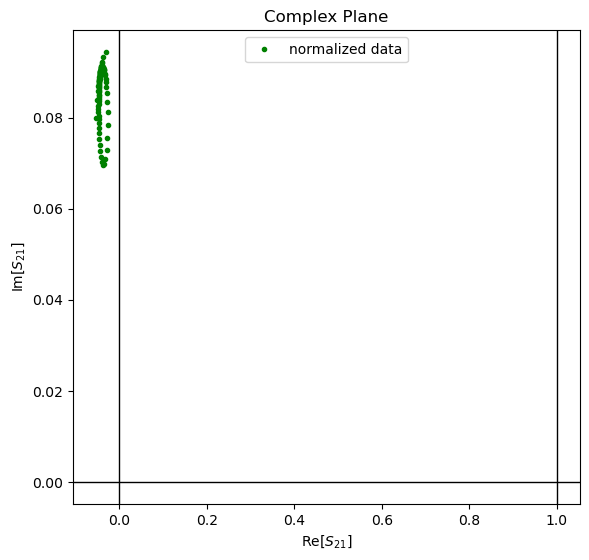

In [9]:
fig2, ax2 = plt.subplots(figsize=(6, 6))

# Complex circle plot on the new figure
ax2.plot(cmplx.real, cmplx.imag, '.', color='green', label="normalized data") 
ax2.set_xlabel("Re[$S_{21}$]")
ax2.set_ylabel("Im[$S_{21}$]")
ax2.axhline(y=0, color='black', linewidth=1)
ax2.axvline(x=1, color='black', linewidth=1)
ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_title("Complex Plane")
ax2.legend()

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the complex plane plot
plt.show()

## Testing scresonators

Initial Guesses:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q       1e+06     1000    1e+09     None     True     None     None
Qc      1e+05     1000    1e+09     None     True     None     None
f0   6.388e+09 6.388e+09 6.388e+09     None     True     None     None
phi      0.08   -1.571    1.571     None     True     None     None

Delay from 'fit_delay':  0.7510719267903816 ns


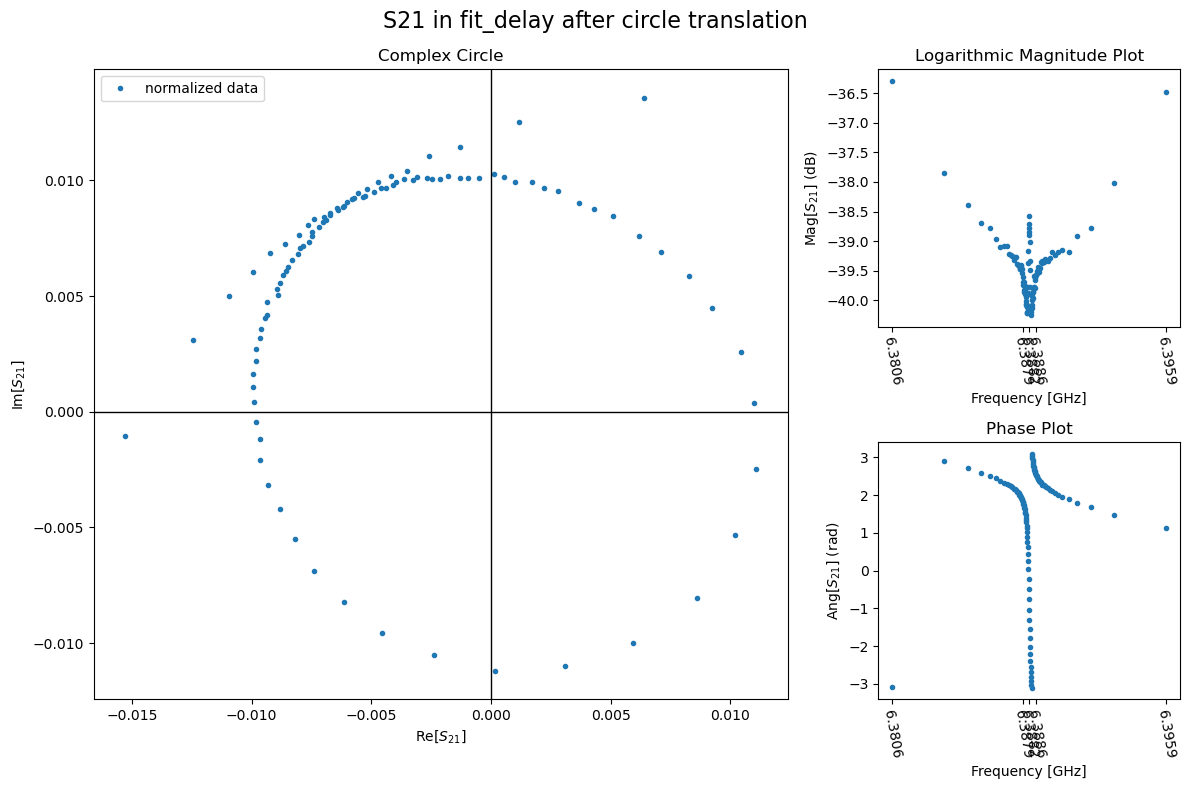

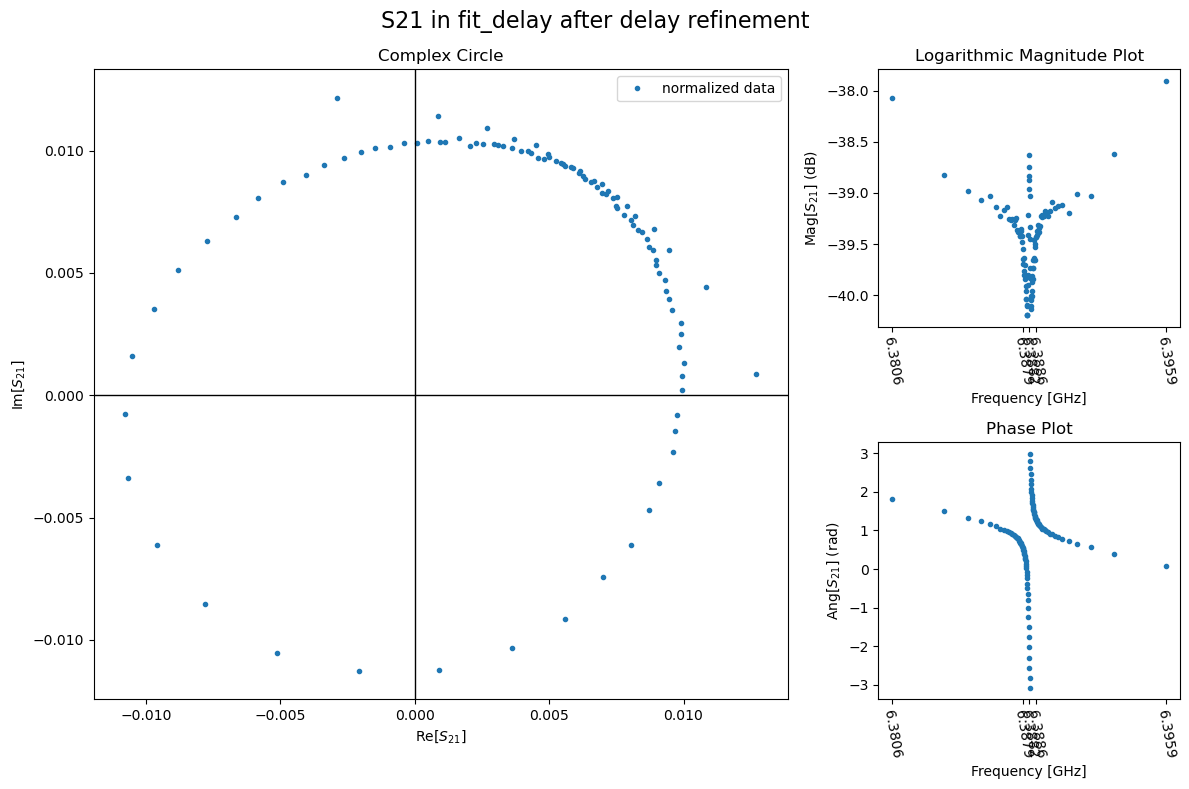

In [10]:
f_0 = freqs[np.abs(cmplx).argmin()]
init_guess = {
    'Q' : {'value' : 1e6, 'min' : 1e3, 'max' : 1e9},
    'Qc' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
    'f0' : {'value' : f_0, 'min' : f_0-3e3, 'max' : f_0+3e3, 'vary' : True},
    'phi' : {'value' : 0.08, 'min' : -np.pi/2, 'max' : np.pi/2}, 
}

init_params = lmfit.create_params(**init_guess)
print("Initial Guesses:")
init_params.pretty_print()
print()

amps = np.abs(cmplx)
db_amps = np.log10(amps) * 20

phases = np.angle(cmplx)
result, conf_intervals, normalized_cmplx_data = FitRes.fit(freqs, db_amps, phases, manual_init=init_params, verbose=False)

fit_result_params = result.params

cmplx_fit = result.eval(params=fit_result_params, x=freqs)

# fit_result_params.pretty_print()

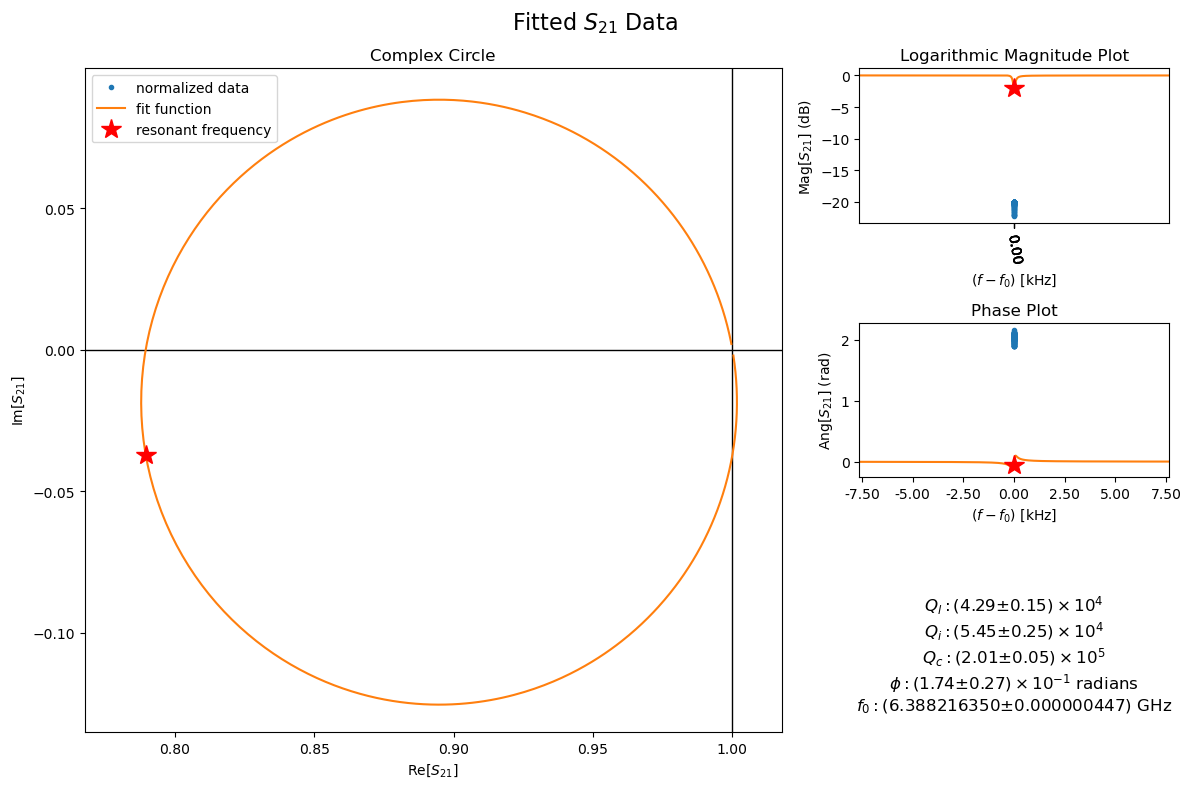

In [11]:
layout = [
        ["main", "main", "mag"],
        ["main", "main", "ang"],
        ["main", "main", "text"]
        ]
fig, ax_dict = plt.subplot_mosaic(layout, figsize=(12, 8))


fig, ax_dict = plot.plot(normalized_cmplx_data, fit_result_params, fig, ax_dict, dcm_method, linear=False, num_fit_points=10000)

## Multiple Resonators

to be implemented

In [12]:
# # load data from Andre
# data_dir = './samples/R0_Jorge/'
# chosen_files = '*'

# freq_dict, cmplx_dict = load_csv(data_dir, chosen_files, idx=None)

# dQ_list, Q_list = [], []

# print(f"# of resonators: {len(freq_dict)}")

# for freq, cmplx in zip(freq_dict.values(), cmplx_dict.values()):

#     FitRes = scres.Fitter(scres.fit_methods.DCM)

#     w1 = freq[np.abs(cmplx).argmin()]
#     init_guess = {
#         'Q' : {'value' : 1e6, 'min' : 1e3, 'max' : 1e9},
#         'Qc' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
#         'w1' : {'value' : w1, 'min' : w1-3e3, 'max' : w1+3e3, 'vary' : True},
#         'phi' : {'value' : 0.08, 'min' : -np.pi/2, 'max' : np.pi/2}, 
#     }

#     init_params = lmfit.create_params(**init_guess)

#     amps = np.abs(cmplx)
#     db_amps = np.log10(amps) * 20

#     phases = np.angle(cmplx)
#     result, conf_intervals = FitRes.fit(freq, db_amps, phases, manual_init=init_params, verbose=True)

#     fit_params = result.params
        
#     y_fit = result.eval(params=fit_params, x=freq)
#     # y_fit_err = result.eval_uncertainty()
#     Q_val = fit_params["Q"].value
#     Q_err = fit_params["Q"].stderr
#     dQ = 100 * Q_err/Q_val
#     print(dQ, Q_val, Q_err)
    
#     dQ_list.append(dQ)
#     Q_list.append(Q_val)


    

In [13]:
# for dQ, Q in zip(dQ_list, Q_list):
    
#     print(f"{dQ:1.2f}, {Q:1.2f}")

# fig, axes = plt.subplots(2,1, figsize=(7,8), sharex=True)
# ax1, ax2 = axes[0], axes[1]

# ax1.plot(dQ_list, 'ro', label="dQ")
# ax1.set_title(r"dQ Values  ($dQ=100 * dQ/\sigma dQ$)")

# ax2.plot(Q_list, 'bo', label="Fit")
# ax2.set_title("Q Values")

# ax2.set_xlabel("Resonator #")